基于协整性检验的跨品种套利策略

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

In [192]:
data = pd.read_csv('data/market_status.csv', index_col='Unnamed: 0')
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data['near_delist_date'] = pd.to_datetime(data['near_delist_date'], format='%Y%m%d')
data['far_delist_date'] = pd.to_datetime(data['far_delist_date'], format='%Y%m%d')
data

,trade_date,open_ih,close_ih,change_ih,amount_ih,open_if,close_if,change_if,amount_if,open_ic,...,label_if_sign_next_day,label_if_sign_next_week,label_if_sign_next_hfmonth,label_if_sign_next_month,label_if_sign_next_hfyear,label_ic_sign_next_day,label_ic_sign_next_week,label_ic_sign_next_hfmonth,label_ic_sign_next_month,label_ic_sign_next_hfyear
0,2017-09-11,2691.3364,2674.7502,-11.9397,4.008527e+07,3828.3422,3825.6453,-0.3442,1.547939e+08,6579.8857,...,True,True,False,True,True,False,True,False,False,False
1,2017-09-12,2682.2494,2692.5401,17.7899,4.484790e+07,3832.2422,3837.9341,12.2888,1.876053e+08,6659.8017,...,True,False,False,True,True,True,False,False,False,False
2,2017-09-13,2690.5596,2687.6707,-4.8694,2.898631e+07,3835.5493,3842.6061,4.6720,1.262544e+08,6635.1693,...,False,False,False,True,True,False,True,False,False,False
3,2017-09-14,2688.3998,2672.8364,-14.8343,3.652983e+07,3843.5720,3829.9554,-12.6507,1.431116e+08,6683.4734,...,True,True,False,True,True,False,False,False,False,False
4,2017-09-15,2669.6530,2668.3759,-4.4605,4.324333e+07,3826.1448,3831.2965,1.3411,1.534772e+08,6661.5211,...,True,True,True,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,2025-09-08,2940.9806,2939.8823,-2.3339,1.537258e+08,4467.1693,4467.5733,7.2484,6.836309e+08,6927.4071,...,False,False,False,False,False,False,False,False,False,False
1860,2025-09-09,2928.5317,2928.6323,-11.2500,1.392414e+08,4448.7390,4436.2584,-31.3149,5.628611e+08,6959.9373,...,True,False,False,False,False,True,False,False,False,False
1861,2025-09-10,2928.1117,2939.5911,10.9588,1.338017e+08,4438.2998,4445.3649,9.1065,5.355393e+08,6911.1119,...,True,False,False,False,False,True,False,False,False,False
1862,2025-09-11,2925.6584,2983.0829,43.4918,1.884955e+08,4438.8390,4548.0345,102.6696,6.931567e+08,6924.3036,...,False,False,False,False,False,True,False,False,False,False


In [193]:
data_test = data[-500:].copy()
data = data[:-500].copy()

In [194]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    adftest = adfuller(data, autolag='AIC')
    print(f"平稳性检验统计量: {adftest[0]:.2f}, P-value: {adftest[1]:.2%}")
    if adftest[1] < 0.05:
        print("拒绝原假设 - 数据是平稳的")
    else:
        print("不能拒绝原假设 - 数据是非平稳的")

adf_test(data['close_ic'])
adf_test(data['change_ic'])

平稳性检验统计量: -2.01, P-value: 28.31%
不能拒绝原假设 - 数据是非平稳的
平稳性检验统计量: -37.08, P-value: 0.00%
拒绝原假设 - 数据是平稳的


标准套路，通过差分找到平稳性阶数，对于价格数据一般都是一阶单整的，同阶单整可以建立协整关系。由于需要利用期货进行多空交易，我们直接采用期货价格

In [195]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(data[['near_price_if']], data['near_price_ic'])
print(model.coef_, model.intercept_)

data['coint_diff_ic_if'] = data['near_price_ic'] - data['near_price_if'] * 1.82
adf_test(data['coint_diff_ic_if'])

from statsmodels.tsa.stattools import coint
coint_test = coint(data['near_price_ic'], data['near_price_if'])
print(f'协整检验统计量: {coint_test[0]:.4f}, P-value: {coint_test[1]:.2%}')

[1.07368009] 1431.7734035239382
平稳性检验统计量: -2.23, P-value: 19.71%
不能拒绝原假设 - 数据是非平稳的
协整检验统计量: -2.5853, P-value: 24.28%


无论是通过回归构建协整关系，还是直接进行协整性检验都没通过。造成这种现象也并不奇怪，因为协整性只能处理差分，最关键的AR性质还没能处理，我们调用ACF和PACF观察构建的协整关系

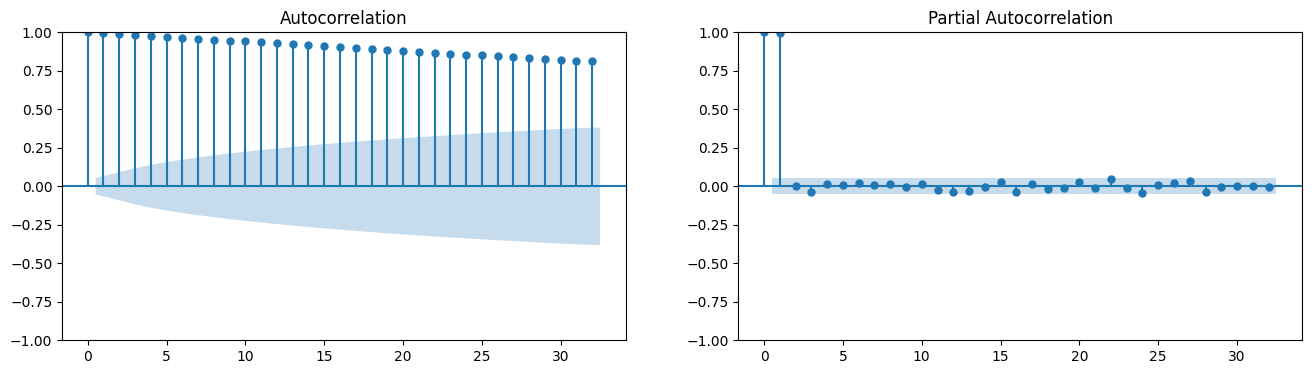

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['coint_diff_ic_if'].dropna(), ax=ax1)
plot_pacf(data['coint_diff_ic_if'].dropna(), ax=ax2)
plt.show()

可以看到非常明显ACF拖尾，PACF截尾，是典型的AR(1) 过程，必须先排除单位根的影响

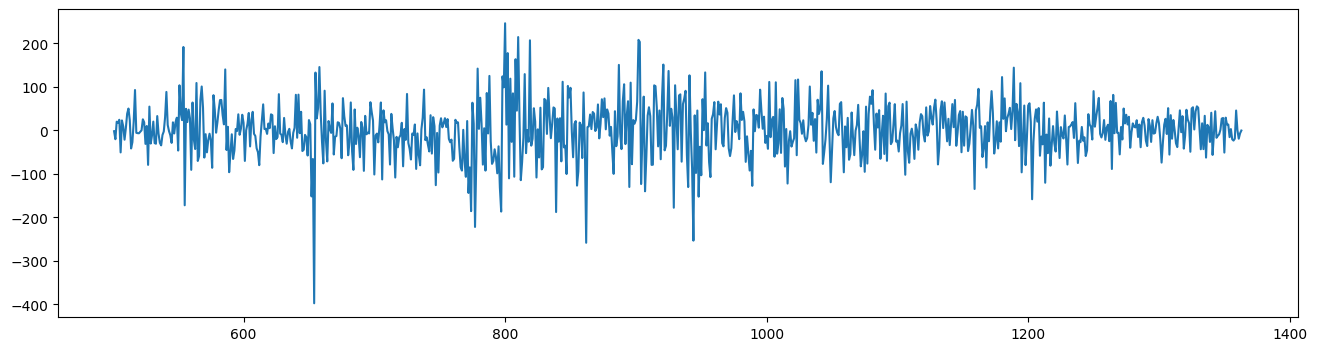

In [197]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data['coint_diff_ic_if'].dropna(), order = (1,0,0))
result = model.fit()
ar_resid = result.resid[1:]
plt.figure(figsize = (16, 4))
plt.plot(ar_resid[500:])

拿到AR过程处理过的残差之后，再进行ACF和PACF检验观察残差的性质

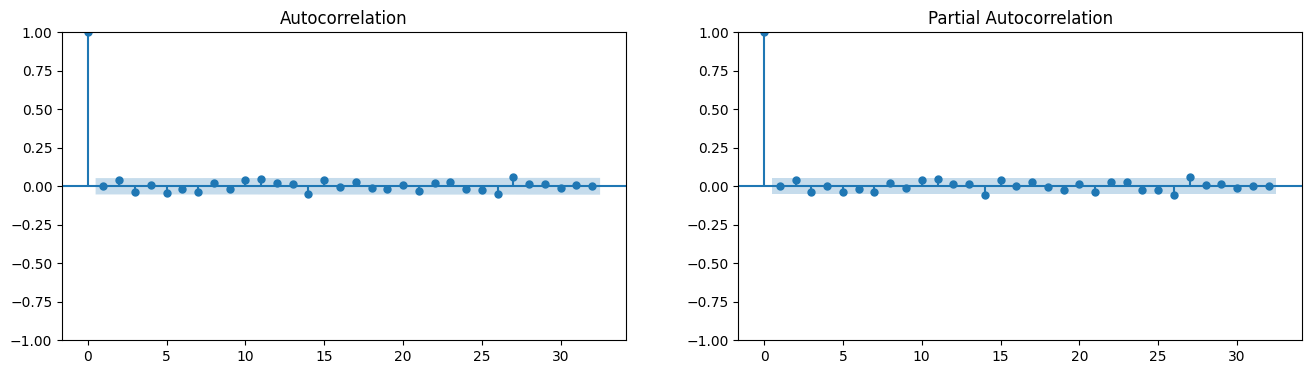

In [198]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ar_resid, ax=ax1)
plot_pacf(ar_resid, ax=ax2)
plt.show()

已经排除了方差具有时间序列性质（MA过程）一般来说这里还需要再检验一下异方差性，不过一般不会影响无偏性，只会影响有效性，影响并不是特别大，并且我们也没有其他外生变量用于检验，简单检验一下是否有时序上的关系，比如随着是关系协整性有没有扩大或破裂的风险

In [199]:
from sklearn.metrics import r2_score
ar_resid_sq = ar_resid * ar_resid
lr = LinearRegression()
time = ar_resid.index.values
lr.fit(time.reshape(-1,1), ar_resid_sq)
sq_resid_pred = lr.predict(time.reshape(-1,1))
r2_score(ar_resid_sq, sq_resid_pred)

2.162734228927654e-05

基本没有关系，可以认为残差已经是白噪声，因此之前构建的AR1已经足够

In [200]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       coint_diff_ic_if   No. Observations:                 1364
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7472.641
Date:                  周三, 17 9月 2025   AIC                          14951.283
Time:                        20:25:28   BIC                          14966.937
Sample:                             0   HQIC                         14957.142
                               - 1364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1669.4263    326.966     -5.106      0.000   -2310.268   -1028.585
ar.L1          0.9969      0.002    623.524      0.000       0.994       1.000
sigma2      3345.5385     81.462     41.069      0.000    3185.876    3505.201
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               517.40
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.30
Prob(H) (two-sided):                  0.73   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

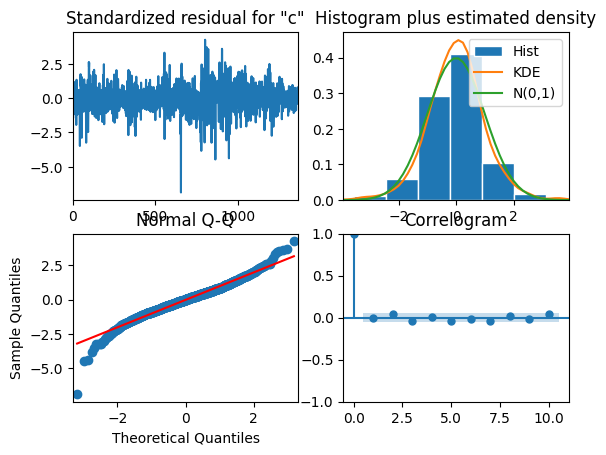

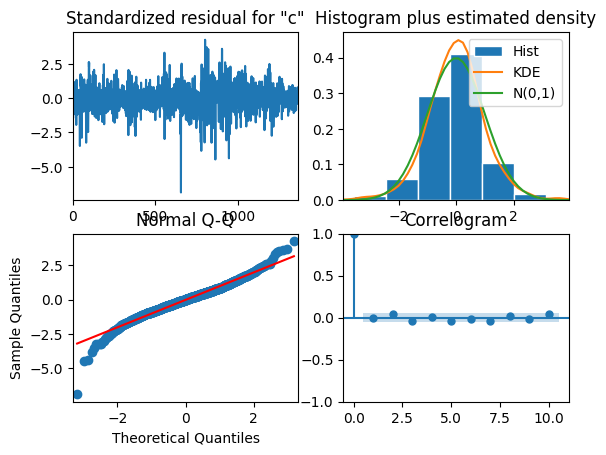

In [201]:
result.plot_diagnostics()

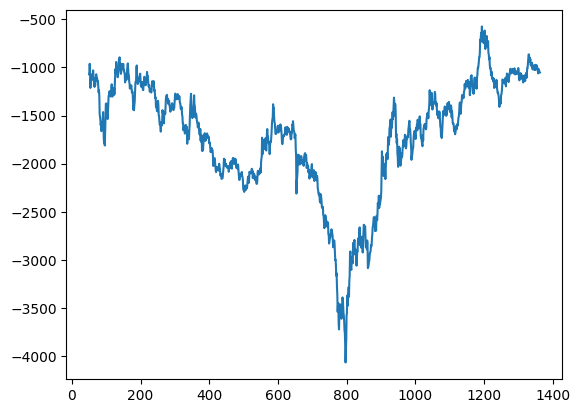

In [202]:
plt.plot(data['coint_diff_ic_if'][50:])

想说一点题外话：

我在UC Davis读研的时候，专业虽然是Agricultural and Resource Economy 但大部分专业课都是围绕微观经济和计量经济（本质上是统计学在经济领域的应用）。学院的主要目的是类似于学说硕的培养研究型人才的方向，基本上就是研究各种经济模型和统计模型，来服务写论文。在学习的过程中，我一直很有疑惑，为什么我们总是关注参数的显著性 mainly focus on parameter, not prediction. 后来慢慢思考之后大概想明白，作为州立大学，更多的是将研究工作服务于政府决策，因此更多的分析是关注于一项潜在政策产生的影响，即parameter，对于经济整体的一个估计反而并不那么重要了。可以说，计量经济的整个研究路径对可解释性的要求是很高的，你很难想象用一个完全黑箱的模型去说服政策制定者，我们需要让每一个模型都具有极强的统计学理论基础才能服务于政策，这是由立场决定的方法。

我认为，整个统计学的思路是这样的：首先，我们提出问题，起初假定问题满足Gauss Markov假设，建立最简单的线性模型；然后根据各种检测方法，分析模型是否真的符合Gauss Markov。对于每一条不满足，开发相应的处理方法，例如对于内生性问题通过工具变量解决，对于异方差问题通过WLS等等。对于每一个自变量，检验其是否有效，筛选出真正有效的变量。随后扩展到时间序列上还是同样的方法，基本上就是围绕 建立模型 - 侦测问题 - 修正问题 - 建立新模型的逻辑。整个研究过程保证了每一步都是严格的论文论证，最终回归到Best Linear Unbiased Estimator的起点。

然而，在当下大数据，大模型的年代，统计学的定位越来越尴尬。一个可解释、有充分理论基础，但是预测效果差的模型，只能当作花瓶，大数据、大模型的发展完全打破了这一切。自变量是否有效？无所谓，不用删变量，都加进来就行，只要足够多，总有有效的自变量能起到预测效果。是不是最优估计？也不重要，只要数据点足够多，力大砖飞也能收敛到最优点。内生性？参数bias又怎么样呢，参数越来越多具体某一个参数是否bias根本不会影响最终结果。似乎我之前小心翼翼想要解决的每一个问题，都被深度学习方法用更加高效率的方法绕开了，或者说根本不在乎这些问题。这点对我来说也是比较大的震撼吧。

当然并不是说统计学就没有意义了，一方面大模型也在追寻可解释性、因果推断等，另一方面对于模型的研发和训练也有指导意义。只是说，深度学习这种结果导向的研究方法，更加适合现实世界的逻辑而不是学术领域的研究。但无论如何，掌握更广阔的视野总不是坏事，有两个工具箱的工程师总会比只有一个工具箱的工程师有更多的解决方案，甚至能交叉出更多的选项。

In [203]:
data.index = data['trade_date']
data = data.asfreq('D')
data = data.dropna()

In [211]:
data

,trade_date,open_ih,close_ih,change_ih,amount_ih,open_if,close_if,change_if,amount_if,open_ic,...,label_if_sign_next_week,label_if_sign_next_hfmonth,label_if_sign_next_month,label_if_sign_next_hfyear,label_ic_sign_next_day,label_ic_sign_next_week,label_ic_sign_next_hfmonth,label_ic_sign_next_month,label_ic_sign_next_hfyear,coint_diff_ic_if
trade_date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,2017-12-13,2850.4681,2872.9400,22.7431,3.384801e+07,4013.8319,4050.0927,34.0764,1.150064e+08,6224.7821,...,False,False,True,False,True,False,False,True,False,-1120.808
2017-12-14,2017-12-14,2874.9463,2850.0458,-22.8942,3.231689e+07,4050.9028,4026.1516,-23.9411,1.150869e+08,6273.6070,...,True,True,True,False,False,False,False,True,False,-1077.704
2017-12-15,2017-12-15,2844.1017,2820.1666,-29.8792,3.557071e+07,4018.7313,3980.8558,-45.2958,1.184741e+08,6274.0975,...,True,True,True,False,False,True,True,True,False,-1031.140
2017-12-18,2017-12-18,2821.4191,2829.0585,8.8919,2.973195e+07,3983.2965,3985.2914,4.4356,1.117243e+08,6229.7416,...,True,True,True,False,True,True,True,True,False,-1090.536
2017-12-19,2017-12-19,2829.5490,2873.0302,43.9717,3.858455e+07,3985.8233,4035.3294,50.0380,1.159982e+08,6200.9337,...,False,True,True,False,False,False,True,True,False,-1126.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,2023-07-17,2535.6389,2520.7864,-27.1529,4.231577e+07,3881.6225,3867.1749,-31.9278,1.746236e+08,6012.7648,...,False,True,False,False,False,False,True,False,False,-1018.600
2023-07-18,2023-07-18,2520.6224,2511.6351,-9.1513,3.942080e+07,3871.0444,3854.9393,-12.2356,1.671043e+08,6015.9819,...,True,True,False,False,False,True,True,False,False,-1020.156
2023-07-19,2023-07-19,2506.4151,2517.1060,5.4709,3.741521e+07,3848.4826,3850.8663,-4.0730,1.513115e+08,5998.3813,...,True,True,False,False,False,True,True,False,False,-1041.360


In [212]:
Exog = data[['close_if', 'close_ih', 'on', 'y1']]
Endog = data['close_ic']

In [213]:
model = ARIMA(endog=Endog, exog = Exog, order = (1,0,0))

c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
